In [42]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

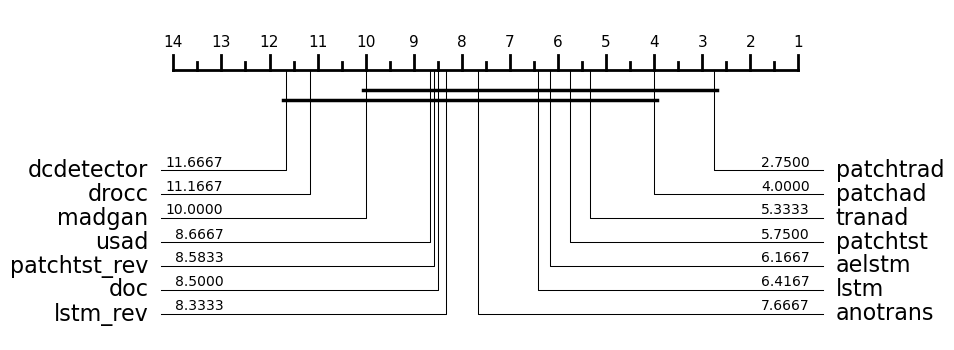

In [43]:
results = pd.read_json("results/aucs.json")
results = results.round(3)

#####
# to delete bc drocc on smd not implemented yet
results.loc['drocc', 'smd'] = 0.5
results = results.T
#####

methods = results.columns
plot = plot_critical_difference(results.values, methods, alpha=0.05, width=8, test='nemenyi')  

In [44]:
results["mean"] = results.mean(axis=1)
results

,aelstm,anotrans,patchtst,usad,lstm,tranad,patchtrad,patchad,madgan,drocc,lstm_rev,patchtst_rev,doc,dcdetector,mean
nyc_taxi,0.664,0.491,0.696,0.675,0.511,0.551,0.922,0.972,0.782,0.529,0.646,0.552,0.704,0.498,0.656643
ec2_request_latency_system_failure,0.998,0.994,0.999,0.977,0.999,0.967,0.999,0.998,0.011,0.886,0.998,0.999,0.804,0.827,0.889714
msl,0.589,0.609,0.560,0.622,0.582,0.622,0.622,0.625,0.499,0.531,0.598,0.562,0.603,0.536,0.582857
swat,0.840,0.819,0.843,0.814,0.842,0.815,0.845,0.822,0.791,0.751,0.238,0.233,0.404,0.435,0.678000
smap,0.614,0.637,0.514,0.448,0.604,0.668,0.629,0.630,0.544,0.569,0.520,0.498,0.583,0.560,0.572714
smd,0.828,0.678,0.882,0.638,0.833,0.884,0.869,0.818,0.708,0.500,0.858,0.873,0.766,0.530,0.761786
